In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

# Read votes

# vd = pd.read_csv('_votesData.csv',index_col=0,dtype={'SubjectID':str,'W':int,'H':int,'Q':str}).reset_index(drop=True)
# vd.head()


In [5]:
td = pd.read_csv('/Users/zhangjiayu/Desktop/toGenHeatmap.csv',index_col=0,dtype={'SubjectID':str,'TrackID':str}).reset_index(drop=True)

#td.loc[td.Pitch>0,'Pitch'] = td[td.Pitch>0]['Pitch']-np.pi # Fix overflow bug
#td.loc['Pitch']=td.Pitch+np.pi/2
td.head()

File  Grade        TrackID  \
0  sitzmann_0007_equirec_8192x4096_jpeg_q90.jpg      3  1544765692446   
1  sitzmann_0007_equirec_8192x4096_jpeg_q90.jpg      3  1544765692446   
2  sitzmann_0007_equirec_8192x4096_jpeg_q90.jpg      3  1544765692446   
3  sitzmann_0007_equirec_8192x4096_jpeg_q90.jpg      3  1544765692446   
4  sitzmann_0007_equirec_8192x4096_jpeg_q90.jpg      3  1544765692446   

  SubjectID  Timestamp      Roll       Yaw     Pitch       track_id  
0         0          0  0.000000  0.000000  0.000000  1544765692446  
1         0         34  0.012739  2.258151 -0.076502  1544765692446  
2         0         67  0.014423  2.256169 -0.082431  1544765692446  
3         0        101  0.016244  2.255958 -0.087472  1544765692446  
4         0        135  0.017880  2.258699 -0.090353  1544765692446

In [6]:

# Convert tracks data frame to numpy

subjects = set(td['SubjectID'])
files = set(td['File'])

for f in files:
    df = td[td.File==f]
    tracks = set(df['TrackID'])
    print(f,len(tracks))
    #continue
    for t in tracks:
        print(t)
        # print(s,t)
        df = df[df.TrackID==t]
        npTrack = np.asarray(df[['Timestamp','Yaw','Pitch','Roll']])
        break
    break


sitzmann_0012_equirec_8192x4096_jpeg_q15.jpg 20
1544718731236


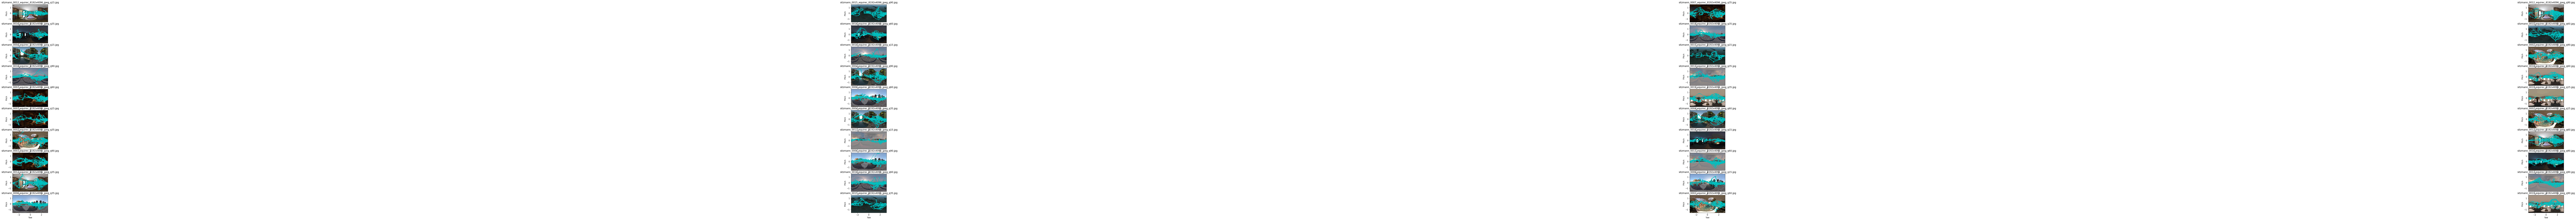

In [8]:
# plot the data
fig = plt.figure(figsize=(300,20))

for i,f in enumerate(files):
    df = td[td.File==f]
    ax = fig.add_subplot(10, 4, i+1)
    img = plt.imread('/Users/zhangjiayu/Desktop/4/stimuli/evaluation/'+f)
    ax.imshow(img,extent=[-np.pi, np.pi, -np.pi/2, np.pi/2])
    ax.scatter(x=df.Yaw,y=(df.Pitch),s=1,c='c')
    plt.xlim((-np.pi,np.pi))
    plt.ylim((-np.pi/2,np.pi/2))
    plt.xlabel('Yaw')
    plt.ylabel('Pitch')
    plt.title(f)
plt.show()



In [9]:
from scipy import signal

tracks = set(td.TrackID)
td2 = td
td2['V'] = 0
td2['Significant'] = True

threshold = 20 # Degrees per second

for track in tracks:
    df = td[td.TrackID==track]
    # Time variable
    t = df.Timestamp * 0.001

    # X and Y components
    x = np.asarray(df.Pitch)
    y = np.asarray(df.Yaw)

    # Compute partial derivatives
    dx = np.diff(x)/np.diff(t)
    dy = np.diff(y)/np.diff(t)
    # print (len(dx), len(dy))
    # print (dx, dy)

    # Filter differentiantion noise
    b, a = signal.butter(8, 0.125)
    dx_filt = signal.filtfilt(b, a, dx)
    dy_filt = signal.filtfilt(b, a, dy)
    
    # dx_filt = signal.filtfilt(b, a, dx, padlen=110)
    # dy_filt = signal.filtfilt(b, a, dy, padlen=110)

    # Compute velocity
    v = np.sqrt(dx_filt**2+dy_filt**2)
    v = v*180/np.pi # Dergrees per second
    v = np.insert(v, 0, 0)
    
    td2.loc[td.TrackID==track,'V'] = v
    td2.loc[td.TrackID==track,'Significant'] = (v <= threshold)
    
    #print("Track "+track+" Done.")



/anaconda3/lib/python3.7/site-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


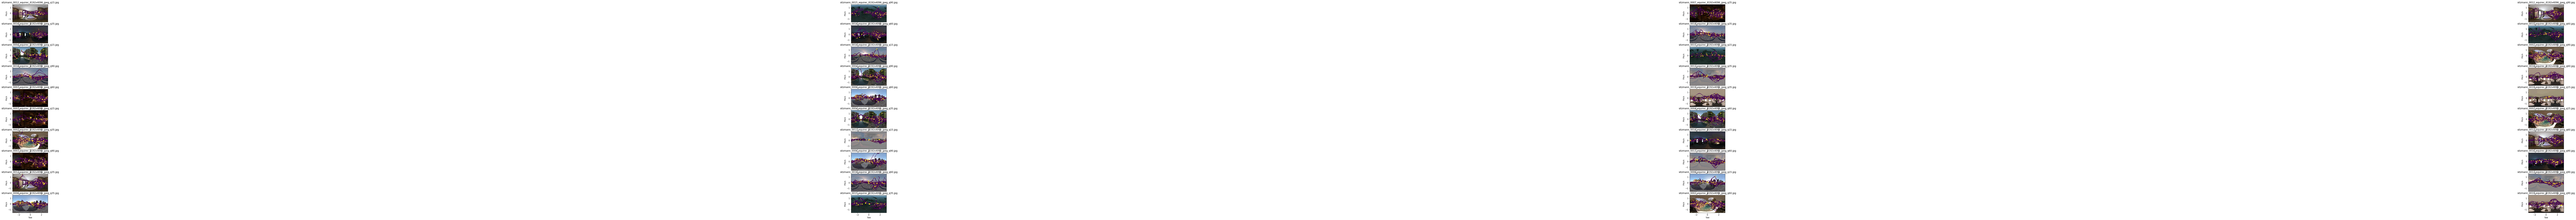

In [10]:
# plot the data
fig = plt.figure(figsize=(300,20))

for i,f in enumerate(files):
    df = td2[td2.File==f]
    ax = fig.add_subplot(10, 4, i+1)
    img = plt.imread('/Users/zhangjiayu/Desktop/4/stimuli/evaluation/'+f)
    ax.imshow(img,extent=[-np.pi, np.pi, -np.pi/2, np.pi/2])
    ax.scatter(x=df.Yaw,y=df.Pitch,s=1,c=df.Significant)
    plt.xlim((-np.pi,np.pi))
    plt.ylim((-np.pi/2,np.pi/2))
    plt.xlabel('Yaw')
    plt.ylabel('Pitch')
    plt.title(f)
plt.show()


In [12]:
W = 8192
H = 4096
points = dict()
fused = dict()
for f in files:
    fixs = np.asarray(td2[(td2.File==f)&td2.Significant][['Yaw','Pitch']])
    print (fixs.size)
    points[f] = fixs
    yaw, pitch = zip(*fixs)
    yaw = np.asarray(yaw)
    pitch = np.asarray(pitch)
    print(yaw.size, pitch.size)
    yaw_q = ((yaw/np.pi) * (W/2)).astype(int) + 4096
    pitch_q = ((pitch/np.pi) * (H/2)).astype(int) + 2048
    print(yaw_q, pitch_q)
    
    # yaw_q = np.round((yaw/np.pi + 1)*(W/2)).astype(int)
    # pitch_q = np.round((0.5 - pitch/np.pi/2)*(H/2)).astype(int)
    
    
    # yaw_q = np.round((yaw/np.pi/2 + 1)*(W/2)).astype(int)
    # pitch_q = np.round((0.5 - pitch/np.pi)*(H/2)).astype(int)
    
    # yaw_q = np.round((0.5-yaw/np.pi/2)*W).astype(int)
    # pitch_q = np.round((pitch/np.pi + 1)*H).astype(int)
    print(yaw_q.size, pitch_q.size)
    # pitch_q = np.round((pitch/np.pi+1)*H).astype(int)
    image = np.zeros((H, W))
    image[pitch_q,yaw_q] = 1
    fused[f] = image
    #fixs_quant = list(set(zip(pitch_q,yaw_q)))


3724
1862 1862
[4096 7071 6586 ... 6227 6232 6239] [2048 1982 2202 ... 2146 2144 2144]
1862 1862
3800
1900 1900
[4096  260 6692 ...  258  258  260] [2048 1912 2048 ... 1997 1998 1997]
1900 1900
5892
2946 2946
[  33   26 8162 ... 1453 1455 1455] [1953 1952 1941 ... 2033 2034 2034]
2946 2946
3890
1945 1945
[4096 7140 3457 ... 6023 6023 6026] [2048 2106 1945 ... 1999 2000 2001]
1945 1945
4040
2020 2020
[4096 6110 7456 ... 8154 8156 8161] [2048 1884 2023 ... 2038 2038 2038]
2020 2020
5048
2524 2524
[4096  648  838 ... 2538 2537 2537] [2048 1832 1840 ... 2061 2061 2059]
2524 2524
6378
3189 3189
[4096  621 2151 ... 6074 6075 6077] [2048 1952 2112 ... 1948 1948 1949]
3189 3189
3076
1538 1538
[4096  358  833 ... 3686 3687 3689] [2048 1965 1999 ... 2028 2027 2028]
1538 1538
4386
2193 2193
[4096 8097 7869 ... 7985 7985 7989] [2048 1977 2006 ... 2047 2048 2047]
2193 2193
3490
1745 1745
[4096 6956 6846 ... 5107 5108 5108] [2048 1958 1964 ... 2107 2107 2109]
1745 1745
2102
1051 1051
[4096 6115 5806

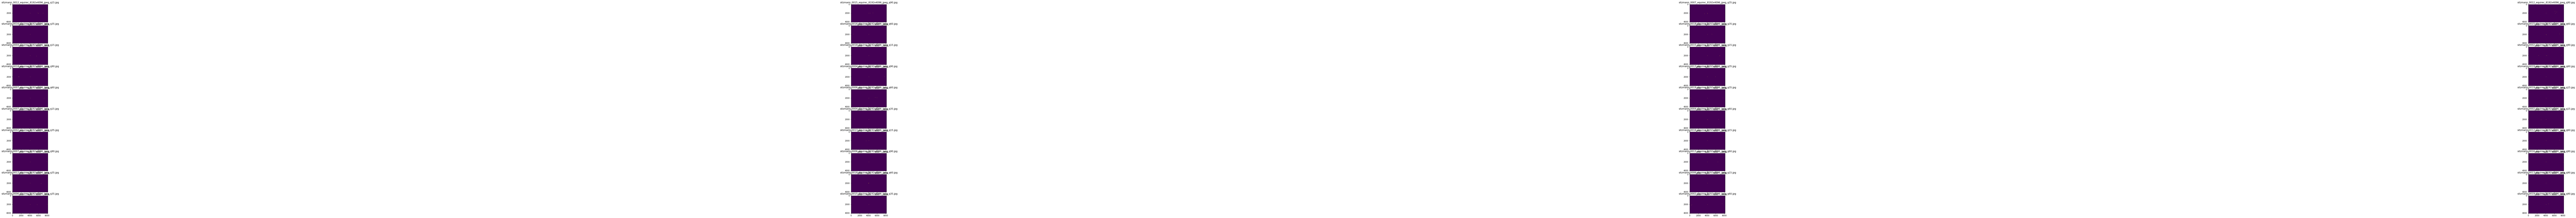

In [14]:
fig = plt.figure(figsize=(300,20))
for i,f in enumerate(files):
    ax = fig.add_subplot(10, 4, i+1)
    #img = plt.imread('../images/'+f)
    ax.imshow(fused[f])
    plt.title(f)
plt.show()

In [ ]:
from scipy.ndimage.filters import gaussian_filter

sigma = 30*(W/360) # 30 degrees

heatmaps = dict()

for f in files:
    print("Filtering "+f+" ...")
    # blurred = gaussian_filter(fused[f], sigma=sigma)
    blurred = gaussian_filter(fused[f], sigma=sigma)
    blurred *= 1.0/blurred.max()
    heatmaps[f] = blurred


Filtering sitzmann_0012_equirec_8192x4096_jpeg_q15.jpg ...
Filtering sitzmann_0015_equirec_8192x4096_jpeg_q90.jpg ...
Filtering sitzmann_0007_equirec_8192x4096_jpeg_q35.jpg ...
Filtering sitzmann_0012_equirec_8192x4096_jpeg_q90.jpg ...
Filtering sitzmann_0016_equirec_8192x4096_jpeg_q35.jpg ...
Filtering sitzmann_0016_equirec_8192x4096_jpeg_q60.jpg ...
Filtering sitzmann_0018_equirec_8192x4096_jpeg_q35.jpg ...
Filtering sitzmann_0015_equirec_8192x4096_jpeg_q60.jpg ...
Filtering sitzmann_0004_equirec_8192x4096_jpeg_q15.jpg ...
Filtering sitzmann_0018_equirec_8192x4096_jpeg_q15.jpg ...
Filtering sitzmann_0015_equirec_8192x4096_jpeg_q15.jpg ...
Filtering sitzmann_0002_equirec_8192x4096_jpeg_q90.jpg ...
Filtering sitzmann_0018_equirec_8192x4096_jpeg_q90.jpg ...
Filtering sitzmann_0004_equirec_8192x4096_jpeg_q90.jpg ...
Filtering sitzmann_0013_equirec_8192x4096_jpeg_q35.jpg ...
Filtering sitzmann_0019_equirec_8192x4096_jpeg_q60.jpg ...
Filtering sitzmann_0007_equirec_8192x4096_jpeg_q60.jpg .

In [407]:
np.save('heatmaps.npy',heatmaps)

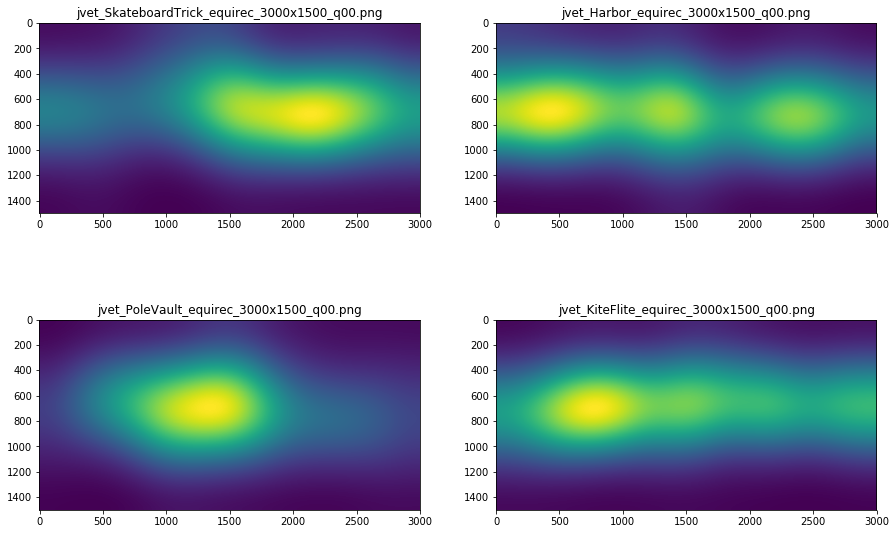

In [405]:
fig = plt.figure(figsize=(15,10))
for i,f in enumerate(files):
    ax = fig.add_subplot(2, 2, i+1)
    #img = plt.imread('../images/'+f)
    ax.imshow(heatmaps[f])
    plt.title(f)
plt.show()

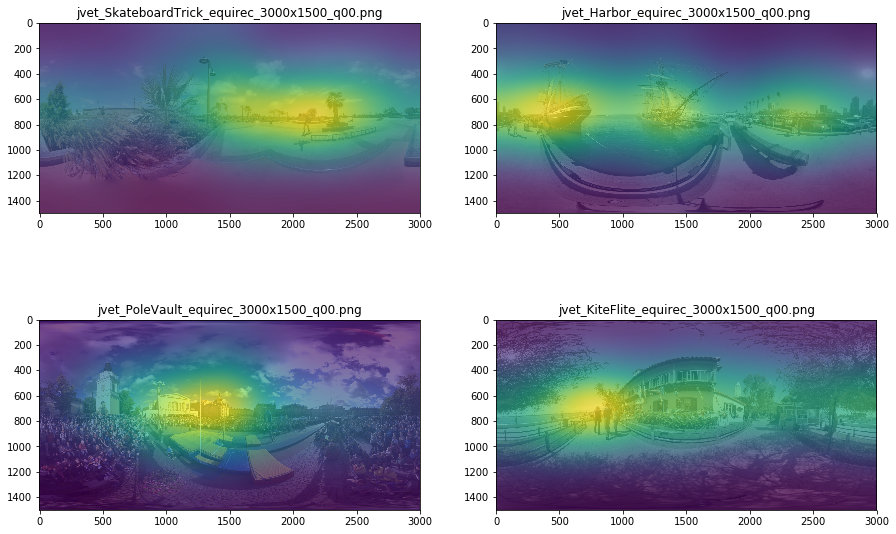

In [406]:
fig = plt.figure(figsize=(15,10))
for i,f in enumerate(files):
    ax = fig.add_subplot(2, 2, i+1)
    img = plt.imread('../images/'+f)
    ax.imshow(img)
    ax.imshow(heatmaps[f],alpha=0.7)
    plt.title(f)
plt.show()

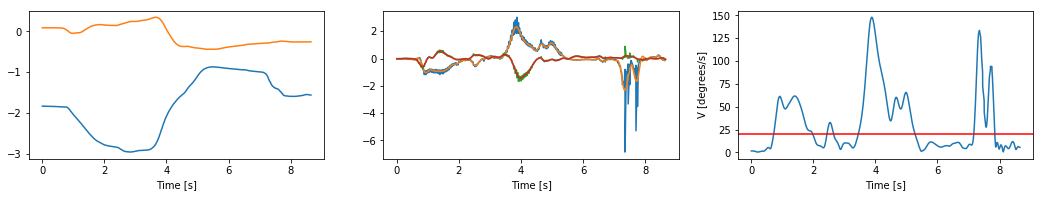

In [276]:
from scipy import signal

df = td[td.TrackID=='1484388414.6567']

# Time variable
t = df.Timestamp

# X and Y components
x = np.asarray(df.Pitch)
y = np.asarray(df.Yaw)

# Compute partial derivatives
dx = np.diff(x)/np.diff(t)
dy = np.diff(y)/np.diff(t)

# Filter differentiantion noise
b, a = signal.butter(8, 0.125)
dx_filt = signal.filtfilt(b, a, dx, padlen=150)
dy_filt = signal.filtfilt(b, a, dy, padlen=150)

# Compute velocity
v = np.sqrt(dx_filt**2+dy_filt**2)
v = v*180/np.pi # Dergrees per second

plt.figure(figsize=(18,6))

plt.subplot(2,3,1)
plt.plot(t,x)
plt.plot(t,y)
plt.xlabel("Time [s]")


plt.subplot(2,3,2)
t = t[1:]
plt.plot(t,dx)
plt.plot(t,dx_filt)
plt.plot(t,dy)
plt.plot(t,dy_filt)
plt.xlabel("Time [s]")

plt.subplot(2,3,3)
plt.plot(t,v)
plt.axhline(20,c='r')
plt.xlabel("Time [s]")
plt.ylabel("V [degrees/s]")

plt.show()

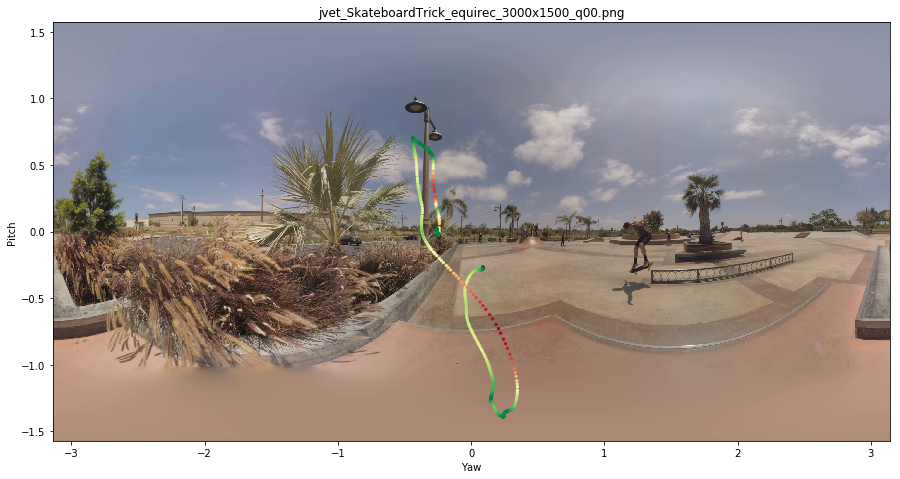

In [277]:
f='jvet_SkateboardTrick_equirec_3000x1500_q00.png' 
img = plt.imread('../images/'+f)

df = td2[td2.TrackID=='1484388414.6567']

plt.figure(figsize=(15,10))
plt.imshow(img,extent=[-np.pi, np.pi, -np.pi/2, np.pi/2])
plt.scatter(x=df.Yaw,y=(df.Pitch+np.pi/2),s=5,c=df.V,cmap='RdYlGn_r')
plt.xlim((-np.pi,np.pi))
plt.ylim((-np.pi/2,np.pi/2))
plt.xlabel('Yaw')
plt.ylabel('Pitch')
plt.title(f)
plt.show()

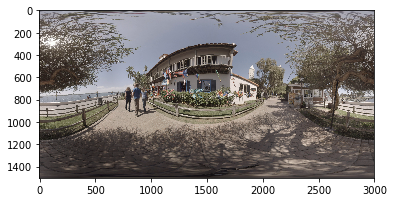

In [309]:


# quntize Y and P to image dimentions
# use bins.
plt.imshow(img)
plt.show()